# Solar loader demo

`SolarLoader` class demonstrations.

Author: Olivier Lamarre  
Affl.: STARS Laboratory, University of Toronto

## Notebook imports and logging setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import logging
import logging.config
import yaml
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.dates as md
from datetime import datetime, timezone
import json
import ipynbname

from gplanetary_nav.solar.loader import load as solar_loader
from gplanetary_nav.planning.types import Node, NodeStamped
from gplanetary_nav.site.loader import load as site_loader
from gplanetary_nav.dev.paths_config import REPO_CFG as GPLANETARY_CFG

# Logging setup
with open(os.path.join(GPLANETARY_CFG.config_dir, 'logging.json')) as f:
    log_cfg = json.load(f)
lfn = os.path.join(GPLANETARY_CFG.logs_dir, ipynbname.name()+'.log')
log_cfg['handlers']['file']['filename'] = lfn
logging.config.dictConfig(log_cfg)
log = logging.getLogger(__name__)
print(f"Logging to {lfn}")


No 'data_dir' param, defaulting to: /home/olamarre/projects/gplanetary-nav-internal/data
No 'logs_dir' param, defaulting to: /home/olamarre/projects/gplanetary-nav-internal/logs
No 'params_dir' param, defaulting to: /home/olamarre/projects/gplanetary-nav-internal/params
No 'config_dir' param, defaulting to: /home/olamarre/projects/gplanetary-nav-internal/config
No 'tests_dir' param, defaulting to: /home/olamarre/projects/gplanetary-nav-internal/tests


Logging to /home/olamarre/projects/gplanetary-nav-internal/logs/25-solar_power_demo.log


## Load solar data

In [2]:
# Dataset path
dirpath = Path(os.environ.get('GNAV_DATASET_PATH'), "CAB240_sample")

rover_cfg_fpath = os.path.join(GPLANETARY_CFG.params_dir, "rover.yaml")
with open(rover_cfg_fpath) as f:
    rover_cfg = yaml.load(f, Loader=yaml.FullLoader)

solar = solar_loader(dirpath, rover_cfg)

log.info(f"Starting date of current model: {str(solar.min_date)} (unix timestamp: {solar.min_time} s)")
log.info(f"Ending date of current model: {str(solar.max_date)} (unix timestamp: {solar.max_time} s)")
log.info(f"Rover solar panel area {solar.area} m^2 with efficiency {100*solar.efficiency}%")

2023-06-19 11:32:05,681 - __main__ - INFO - Starting date of current model: 2029-09-27 08:33:20 (unix timestamp: 1885192400 s)
2023-06-19 11:32:05,682 - __main__ - INFO - Ending date of current model: 2029-10-26 08:33:20 (unix timestamp: 1887698000.0 s)
2023-06-19 11:32:05,683 - __main__ - INFO - Rover solar panel area 1.5 m^2 with efficiency 30.0%


2023-06-19 11:32:07,831 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:07,883 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:07,900 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:07,902 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:07,933 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.


Text(0.5, 1.0, 'Irradiance map (W/m^2) for 2029-09-27 11:30:00\nInvalid data set to 0.\n(Areas with invalid irradiance data darkened)')

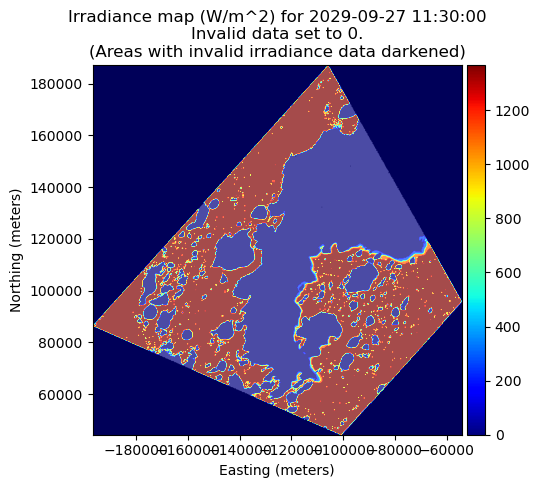

In [3]:
# Irradiance map/array at a specific timestamp
irradiance_arr = solar.map_at_timestamp(timestamp=1885203000)

# Mask of locations where the irradiance data is invalid (solely based on data from 1st irradiance map)
nogo_irradiance_arr = solar.nogo

# Convenience irradiance map plotting function
fig, ax = plt.subplots()
ax = solar.plot_irradiance_map(ax, timestamp=1885203000)

ax.imshow(1-nogo_irradiance_arr, cmap='gray', extent=solar.extent, alpha=0.3)
ax.set_title(ax.get_title()+"\n(Areas with invalid irradiance data darkened)")


2023-06-19 11:32:11,826 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,844 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,863 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,881 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,900 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,918 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, returning solar constant instead.
2023-06-19 11:32:11,937 - gplanetary_nav.solar.loader - WARNING - Max irradiance of preprocessed data not found, retur

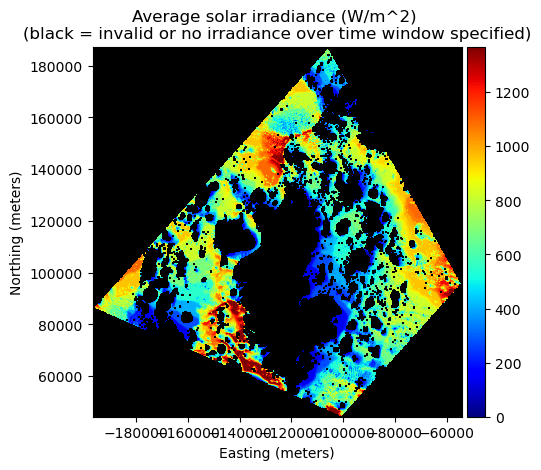

In [4]:
# Average irradiance map/array between two timestamps
avg_irradiance_arr = solar.average_irradiance_map(time_start=1885203000, time_end=1886056400)

# Convenience average irradiance map plotting function
fig, ax = plt.subplots()
ax = solar.plot_average_irradiance_map(ax, time_start=1885203000, time_end=1886056400)

## Power & energy generation prediction

The following assumes that the preprocessing script was ran and irradiance timeseries were calculated for each pixel in free space according to the current site configuration (refer to the wiki for more details):

```py
from gplanetary_nav.solar.preprocessing import create_pixel_intervals
create_pixel_intervals(dataset_path)
```

In [8]:
from gplanetary_nav.solar.preprocessing import create_pixel_intervals
create_pixel_intervals(dirpath, num_cpus=10)

Removing old directory /media/starslab/users/olivier-lamarre/data/planetary_maps/CAB240_sample/irradiance/pixel_intervals (might take a few mins)
New directory created: /media/starslab/users/olivier-lamarre/data/planetary_maps/CAB240_sample/irradiance/pixel_intervals
Created & saved irradiance no-go file at /media/starslab/users/olivier-lamarre/data/planetary_maps/CAB240_sample/nogo_irradiance.tif
2023-06-19 11:34:10,946 - gplanetary_nav.site.loader - INFO - Loading dataset from: /media/starslab/users/olivier-lamarre/data/planetary_maps/CAB240_sample
2023-06-19 11:34:10,951 - gplanetary_nav.site.loader - INFO - Loading dem
2023-06-19 11:34:10,957 - gplanetary_nav.site.loader - INFO - Loading slope
2023-06-19 11:34:10,963 - gplanetary_nav.site.loader - INFO - Loading aspect
2023-06-19 11:34:10,968 - gplanetary_nav.site.loader - INFO - Loading nogo_roi2.tif
2023-06-19 11:34:10,970 - gplanetary_nav.site.loader - INFO - No 'other' layers provided
2023-06-19 11:34:10,971 - gplanetary_nav.si

2023-06-19 11:32:25,645 - gplanetary_nav.site.loader - INFO - Loading dataset from: /media/starslab/users/olivier-lamarre/data/planetary_maps/CAB240_sample
2023-06-19 11:32:25,648 - gplanetary_nav.site.loader - INFO - Loading dem
2023-06-19 11:32:25,654 - gplanetary_nav.site.loader - INFO - Loading slope
2023-06-19 11:32:25,661 - gplanetary_nav.site.loader - INFO - Loading aspect
2023-06-19 11:32:25,667 - gplanetary_nav.site.loader - INFO - Loading nogo_roi2.tif
2023-06-19 11:32:25,669 - gplanetary_nav.site.loader - INFO - No 'other' layers provided
2023-06-19 11:32:25,670 - gplanetary_nav.site.loader - INFO - Loading site CAB240_sample with layers ['dem', 'slope', 'aspect', 'nogo_roi2'] at lat-lon (-84.670, 305.557) deg. on reference body: moon
2023-06-19 11:32:25,694 - gplanetary_nav.site.loader - INFO - Dataset CAB240_sample was loaded


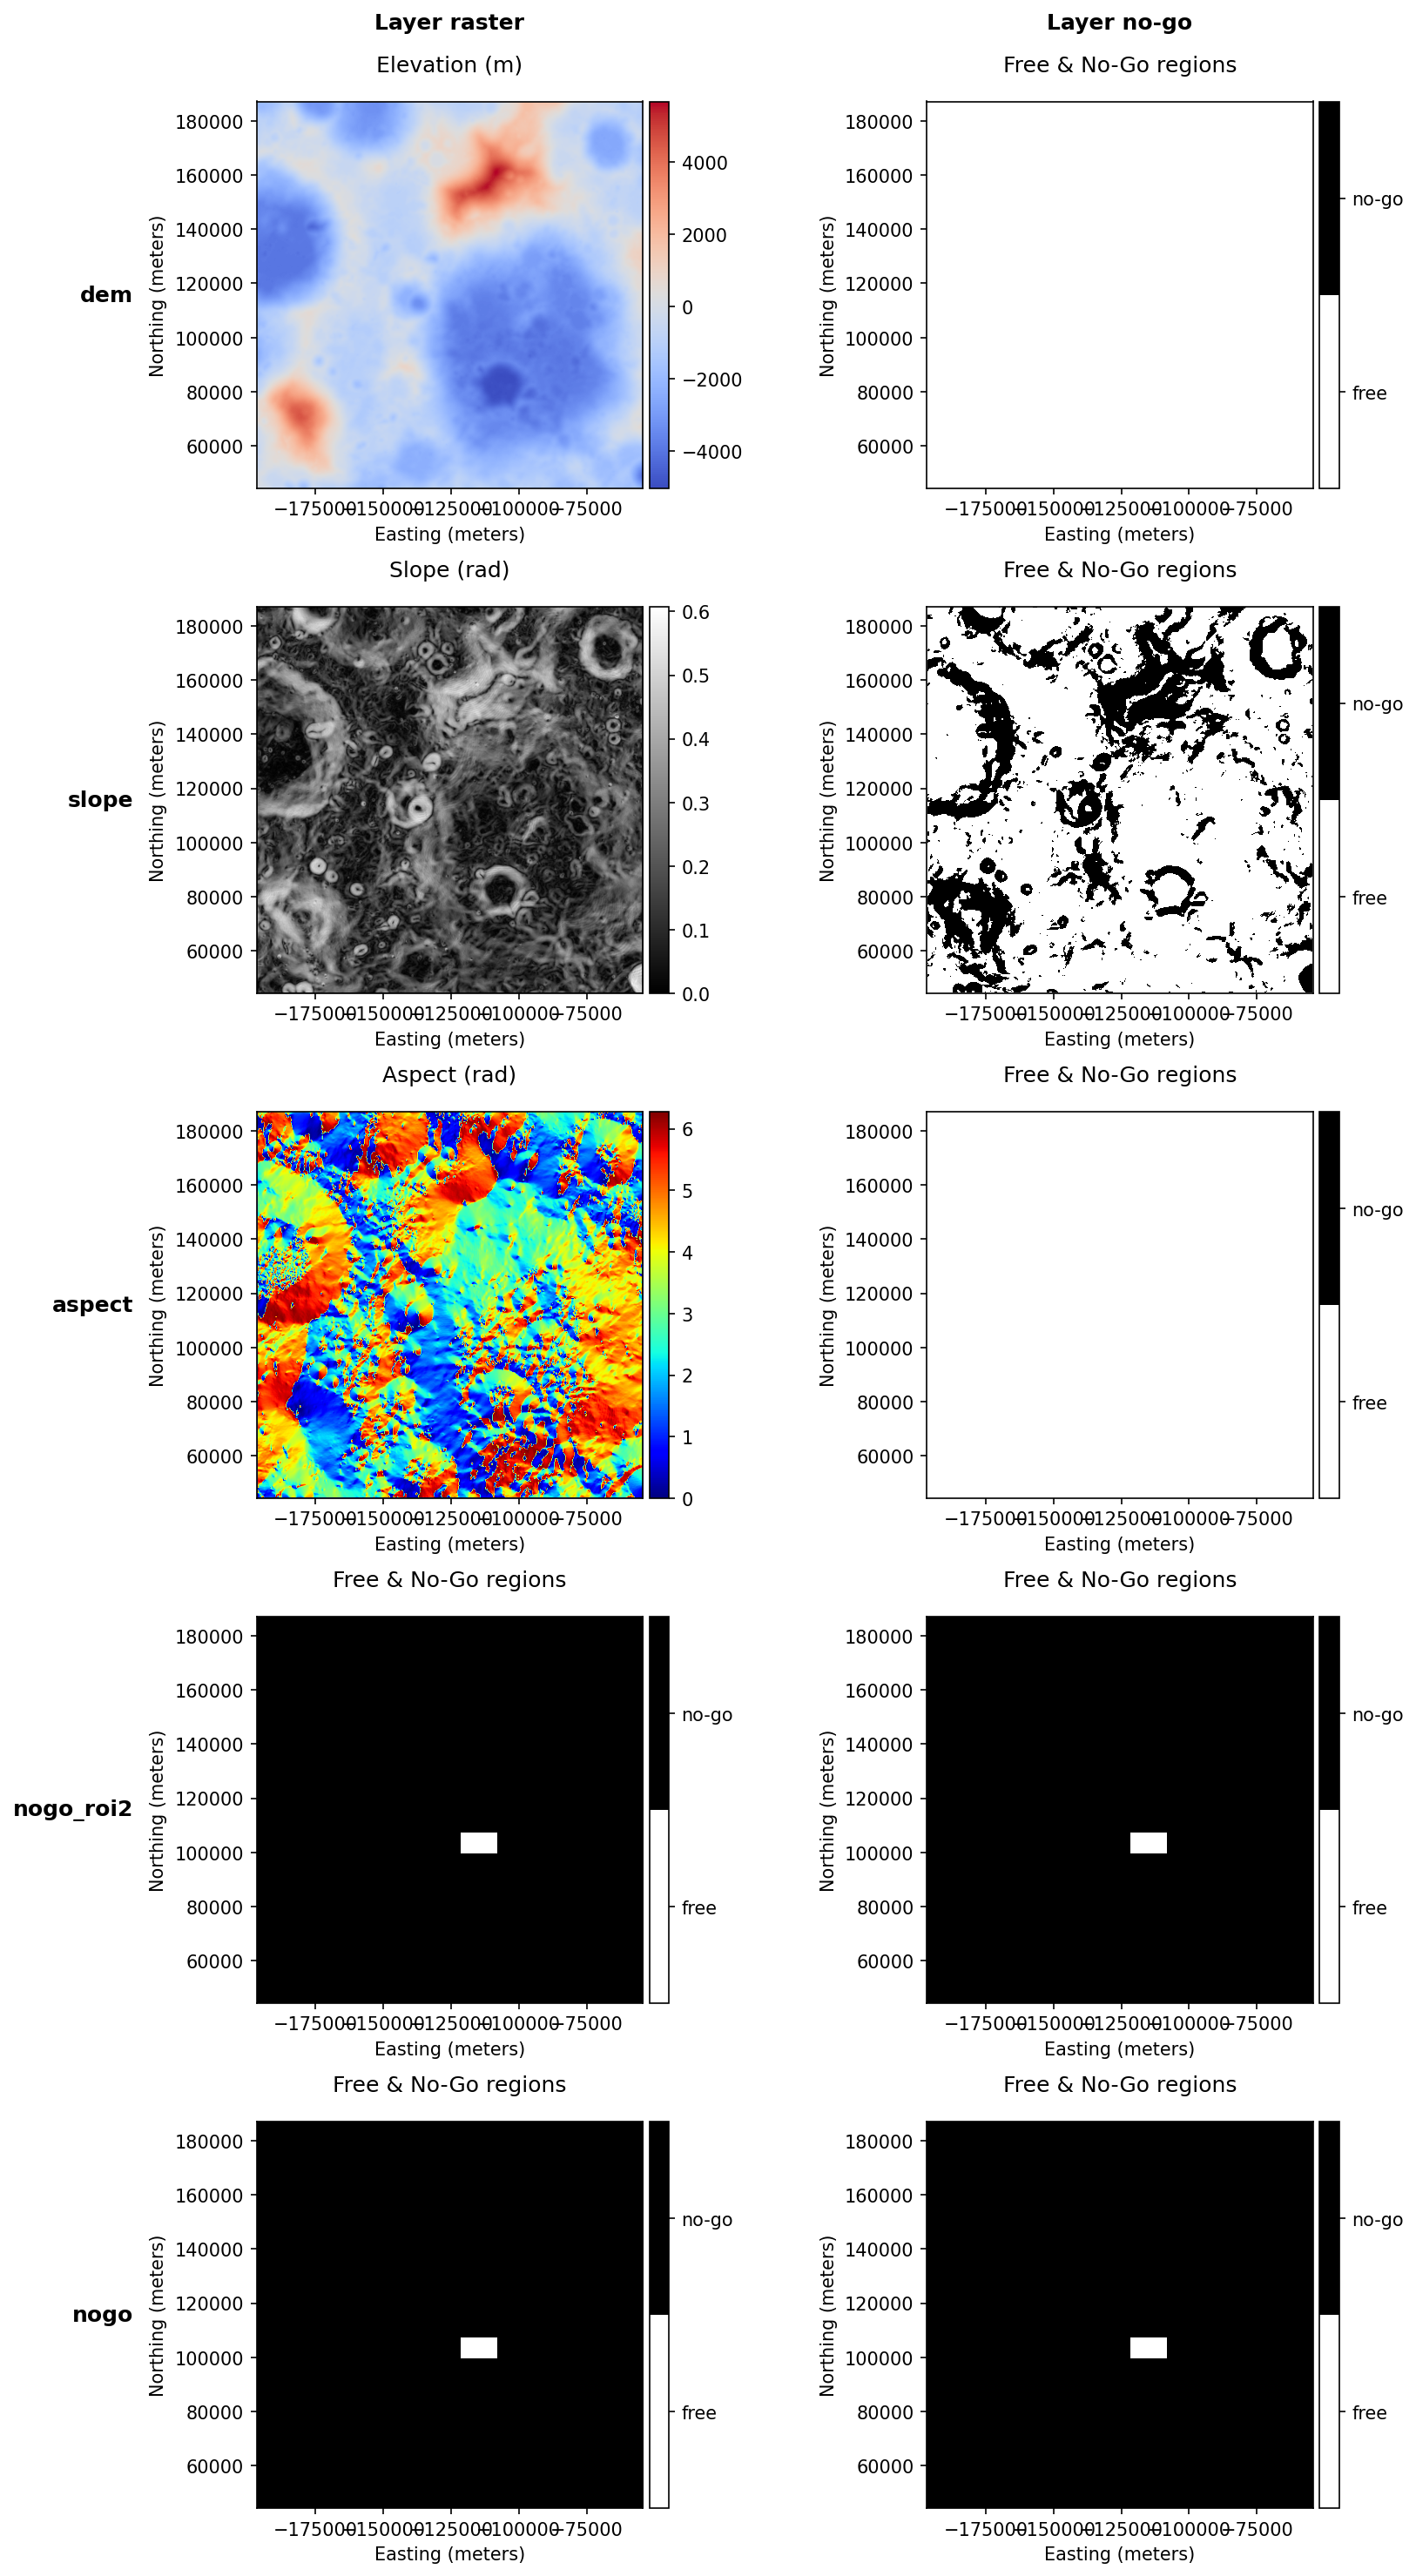

In [5]:
# Show site configuration, for reference
dirpath = Path(os.environ.get('GNAV_DATASET_PATH'), "CAB240_sample")
site = site_loader(dirpath)
site.plot_all()

Text(0.5, 1.0, 'Solar irradiance over dataset timespan at location (333, 363)')

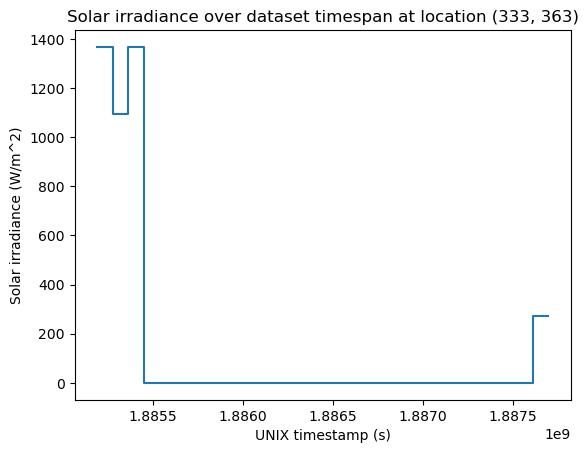

In [9]:
# Retrieve valid pixel coordinate that is not in a PSR
# coord = next(iter(site.valid_coords.difference(solar.psr_coords)))
coord = (333,363)

# Solar irradiance timeseries at that location
# (add irradiance at end of dataset timespan for more complete profile plot)
irr_ts = solar.irradiance_timeseries(coord)
irr_ts = np.vstack((
    irr_ts,
    np.array([solar.max_time, irr_ts[-1,1]])
))

# Plot solar power timeseries at that location
fig, ax = plt.subplots()
ax.step(irr_ts[:,0], irr_ts[:,1], where='post')
ax.set_xlabel("UNIX timestamp (s)")
ax.set_ylabel("Solar irradiance (W/m^2)")
ax.set_title(f"Solar irradiance over dataset timespan at location {coord}")

Text(0.5, 1.0, 'Solar power generated over dataset timespan at location (333, 363)')

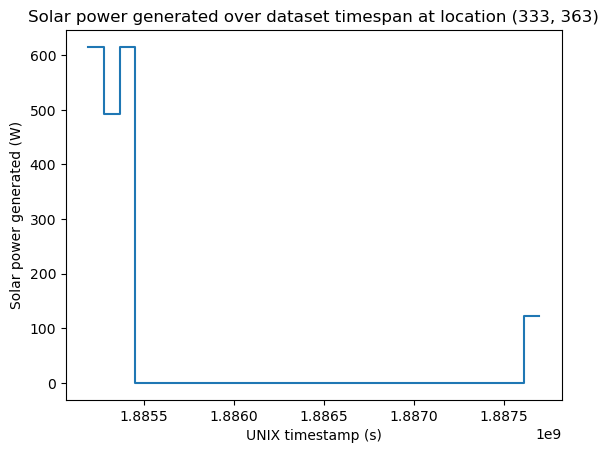

In [10]:
# Power timeseries at that location
# This takes into account the current rover model (solar panel area & efficiency)
# (add power at end of dataset timespan for more complete profile plot)
power_ts = solar.power_timeseries(coord)
power_ts = np.vstack((
    power_ts,
    np.array([solar.max_time, power_ts[-1,1]])
))

# Plot solar power timeseries at that location
fig, ax = plt.subplots()
ax.step(power_ts[:,0], power_ts[:,1], where='post')
ax.set_xlabel("UNIX timestamp (s)")
ax.set_ylabel("Solar power generated (W)")
ax.set_title(f"Solar power generated over dataset timespan at location {coord}")

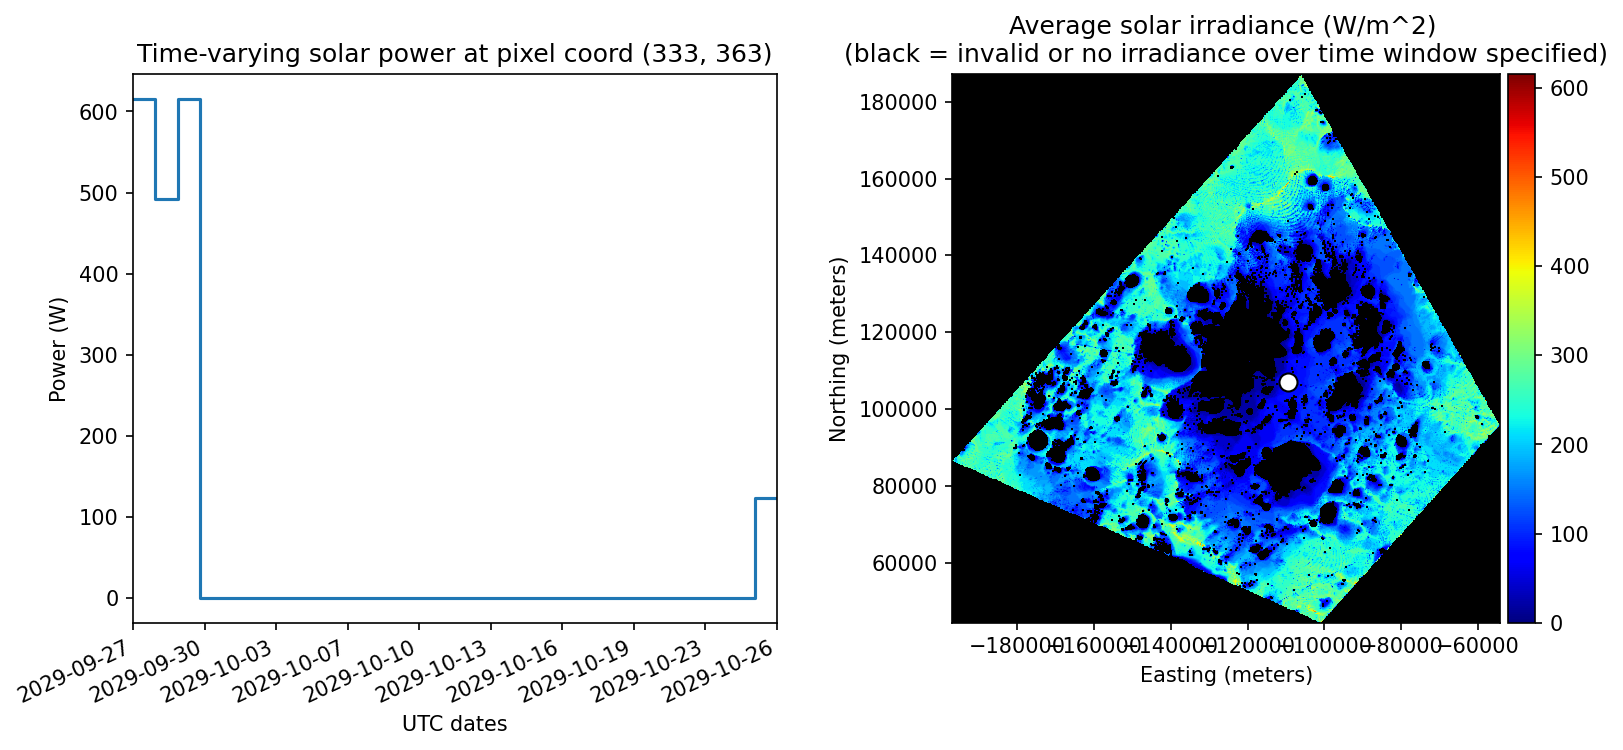

In [11]:
# Same, but also show coordinate location and dates instead of timestamp

# Instead of showing the unix timestamps, use the equivalent datetime
dates = [datetime.utcfromtimestamp(ts) for ts in power_ts[:,0]]
dates = md.date2num(dates)

fig, axes = plt.subplots(1,2,figsize=(11,5), dpi=150, squeeze=False)

ax = axes[0,0]
ax.step(dates, power_ts[:,1], where='post')

ax.set_xlabel("UTC dates")
ax.set_ylabel("Power (W)")
ax.set_title(f"Time-varying solar power at pixel coord {coord}")

ax.set_xlim(dates[0],dates[-1])
ax.set_xticks(np.linspace(ax.get_xbound()[0], ax.get_xbound()[1], 10))

xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()
plt.draw() # required so that the next line does not erase everything
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

ax = axes[0,1]
# ax = site.layers['dem'].plot(ax=ax, cmap='coolwarm')
ax = solar.plot_average_irradiance_map(ax)
ax.scatter(*site.UTM_from_grid(coord), c='w', s=75, edgecolors='k')

plt.tight_layout()
# plt.savefig("/tmp/solar_power.png", dpi=75, bbox_inches="tight")

In [12]:
# Solar power generated at specific instant
ns = NodeStamped(coord, 1885314848)
solar.power(ns)

492.11996

In [13]:
# Solar energy generated over a 72-hours time interval (Wh)
solar.energy(node=coord, t_bounds=(1885314848, 1885314848+72*3600))

21653.27839328342

In [14]:
%timeit solar.energy(node=coord, t_bounds=(1885314848, 1885314848+72*3600))

129 µs ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
# Same calculation, but using a numba-optimized method
solar.load_all_timeseries() # necessary to use numba
solar.energy(node=coord, t_bounds=(1885314848, 1885314848+72*3600))

<string>:3: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, C), array(float32, 1d, A))


21653.27839328342

In [16]:
%timeit solar.energy(node=coord, t_bounds=(1885314848, 1885314848+72*3600))

1.18 µs ± 7.85 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Animate!

Create a video of all solar irradiance maps over time

2023-06-19 11:41:01,176 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-19 11:41:01,178 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x1500 -pix_fmt rgba -r 6.666666666666667 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y /home/olamarre/projects/gplanetary-nav-internal/data/test.mp4


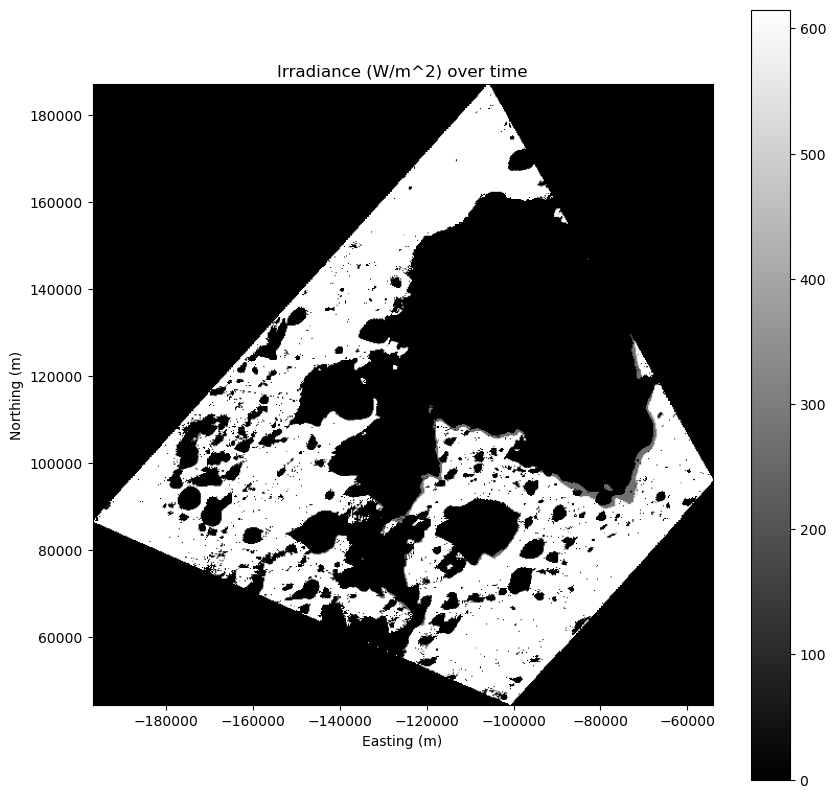

In [18]:
solar.create_animation(Path(GPLANETARY_CFG.data_dir, 'test.mp4'))

In [19]:
# Play it!
from IPython.display import Video
Video(
    data=Path(GPLANETARY_CFG.data_dir, 'test.mp4'),
    embed=True,
    width=1000)

## Apparent Azimuth & Elevation of bodies
Uses JPL's Horizons servers, **requires an internet connection**

In [20]:
# Documentation:
# https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html

from astroquery.jplhorizons import Horizons


# IDs of different bodies
# (to avoid name confusions, it's always better to specify bodies by their ID)
id_from_name = {
    'sun': 10,
    'moon': 301,
    'earth': 399,
    'mars': 499
}

loc = {
    'lon': site.center_longitude,    # Longitude (+ve Eastward)
    'lat': site.center_latitude,      # Latitude w.r.t. equator, decimal degrees (+ve: Northward, -ve: Southward)
    'elevation': 0,     # Elevation above reference ellipsoid (km)
    'body': id_from_name[site.reference_body]         # ID of body where observer is located
}

# Either:
# a floating point (decimal Julian date) or,
# a list of floating points (decimal Julian dates) or,
# a dictionary (of start & stop date/time and step).
# (Julian dates and date/time refer to UTC)
epochs = {
    'start': '2022-06-07 00:00:00',
    'stop' : '2022-07-07 00:00:00',
    'step': '1d' # 1 day: '1d', 1 hour: '1h', 1 minute: '1m', etc.
}

obj = Horizons(
    id=id_from_name['sun'],          # ID (or string name) of body to observe
    location=loc,   # Location of observer
    epochs=epochs   # Time(s)
)

# Generate the data table
ephe = obj.ephemerides()
ephe

targetname,datetime_str,datetime_jd,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,IB_elong,IB_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str8,str17,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,str1,float64,float64,float64,int64,int64,str3,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64
Sun (10),2022-Jun-07 00:00,2459737.5,,i,74.59171,22.6683,130.22707,0.62266,143.2138,3.725516,144.42861,-4.963181,-30.51,1.59,0.0,0.0,0.0,--,999,--,-26.711,-10.589,100.0,0.0,0.0,-,1891.898,231.338956,0.020286,--,--,n.a,--,351.3182,945.949,--,--,0.0,0.0,1.01447856016542,1.1300325,8.43716091,0.0,29.3017729,0.0,/?,0.0,97.0,56.1981,0.0,0.0,180.0,-0.74184,Tau,69.184793,75.8024585,-0.0150809,286.13,63.87,179.216442,-12.314669,--,0.021912,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0,75.8081,-0.0151
Sun (10),2022-Jun-08 00:00,2459738.5,,i,75.62478,22.76754,131.18504,0.64248,144.1176,3.800074,132.193327,-4.229494,-30.47,2.04,0.0,0.0,0.0,--,999,--,-26.71,-10.589,100.0,0.0,0.0,-,1890.679,218.105191,0.139914,--,--,n.a,--,351.3353,945.337,--,--,0.0,0.0,1.01513256162894,1.128355,8.44260007,0.0,29.5056233,0.0,/?,0.0,85.3,46.0615,0.0,0.0,180.0,-0.72272,Tau,69.184768,76.7604965,-0.0137721,286.13,63.87,179.712691,-11.488803,--,0.02162,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0,76.7661,-0.0138
Sun (10),2022-Jun-09 00:00,2459739.5,,i,76.66585,22.86128,132.1491,0.66411,145.0372,3.860778,119.987901,-3.336075,-30.43,2.39,0.0,0.0,0.0,--,999,--,-26.708,-10.589,100.0,0.0,0.0,-,1889.484,204.877566,0.259695,--,--,n.a,--,351.3564,944.732,--,--,0.0,0.0,1.01577423908825,1.0868107,8.44793674,0.0,29.7109979,0.0,/?,0.0,73.3,35.7765,0.0,0.0,180.0,-0.70385,Tau,69.184743,77.7246412,-0.0118737,286.13,63.87,180.208668,-10.65654,--,0.021293,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0,77.7303,-0.0119
Sun (10),2022-Jun-10 00:00,2459740.5,,i,77.71483,22.94925,133.11922,0.68782,145.9312,3.90239,107.809849,-2.325031,-30.39,2.63,0.0,0.0,0.0,--,999,--,-26.707,-10.589,100.0,0.0,0.0,-,1888.359,191.656049,0.379662,--,--,n.a,--,351.3811,944.159,--,--,0.0,0.0,1.0163797266534,1.0026968,8.45297243,0.0,29.9088588,0.0,/?,0.0,60.9,25.786,0.0,0.0,180.0,-0.68517,Tau,69.184717,78.6948635,-0.0094615,286.13,63.87,180.704605,-9.817995,--,0.020948,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0,78.7006,-0.0094
Sun (10),2022-Jun-11 00:00,2459741.5,,i,78.77131,23.03116,134.09505,0.71369,146.7496,3.919571,95.652966,-1.243284,-30.37,2.75,0.0,0.0,0.0,--,999,--,-26.706,-10.589,100.0,0.0,0.0,-,1887.348,178.4403,0.49985,--,--,n.a,--,351.409,943.638,--,--,0.0,0.0,1.01692405822091,0.87

In [21]:
timestamps = []
for row in ephe:

    dt = datetime.strptime(row['datetime_str'], '%Y-%b-%d %H:%M').replace(tzinfo=timezone.utc)
    print(f"Datetime str (UTC): {row['datetime_str']} \t(unix timestamp: {dt.timestamp()}s) \tazimuth: {row['AZ']:.2f}deg \televation: {row['EL']:.2f}deg")

    timestamps.append(dt.timestamp())

Datetime str (UTC): 2022-Jun-07 00:00 	(unix timestamp: 1654560000.0s) 	azimuth: 144.43deg 	elevation: -4.96deg
Datetime str (UTC): 2022-Jun-08 00:00 	(unix timestamp: 1654646400.0s) 	azimuth: 132.19deg 	elevation: -4.23deg
Datetime str (UTC): 2022-Jun-09 00:00 	(unix timestamp: 1654732800.0s) 	azimuth: 119.99deg 	elevation: -3.34deg
Datetime str (UTC): 2022-Jun-10 00:00 	(unix timestamp: 1654819200.0s) 	azimuth: 107.81deg 	elevation: -2.33deg
Datetime str (UTC): 2022-Jun-11 00:00 	(unix timestamp: 1654905600.0s) 	azimuth: 95.65deg 	elevation: -1.24deg
Datetime str (UTC): 2022-Jun-12 00:00 	(unix timestamp: 1654992000.0s) 	azimuth: 83.51deg 	elevation: -0.14deg
Datetime str (UTC): 2022-Jun-13 00:00 	(unix timestamp: 1655078400.0s) 	azimuth: 71.37deg 	elevation: 0.93deg
Datetime str (UTC): 2022-Jun-14 00:00 	(unix timestamp: 1655164800.0s) 	azimuth: 59.22deg 	elevation: 1.93deg
Datetime str (UTC): 2022-Jun-15 00:00 	(unix timestamp: 1655251200.0s) 	azimuth: 47.05deg 	elevation: 2.80deg


In [23]:
# Similar, but using our custom ephemeris module

from gplanetary_nav.solar import ephemeris

ephe = ephemeris.Ephemeris(site.center_latitude, site.center_longitude, 0, site.reference_body)
ephe_df = ephe.az_el_from_timestamps(timestamps, target_name='sun')
ephe_df

,datetime_str,unix_timestamp_s,azimuth_deg,elevation_deg
0,2022-Jun-07 00:00:00,1.654560e+09,144.428610,-4.963181
1,2022-Jun-08 00:00:00,1.654646e+09,132.193327,-4.229494
2,2022-Jun-09 00:00:00,1.654733e+09,119.987901,-3.336075
3,2022-Jun-10 00:00:00,1.654819e+09,107.809849,-2.325031
4,2022-Jun-11 00:00:00,1.654906e+09,95.652966,-1.243284
5,2022-Jun-12 00:00:00,1.654992e+09,83.508410,-0.140433
6,2022-Jun-13 00:00:00,1.655078e+09,71.366150,0.933365
7,2022-Jun-14 00:00:00,1.655165e+09,59.216557,1.929444
8,2022-Jun-15 00:00:00,1.655251e+09,47.051896,2.802555
9,2022-Jun-16 00:00:00,1.655338e+09,34.867508,3.512686


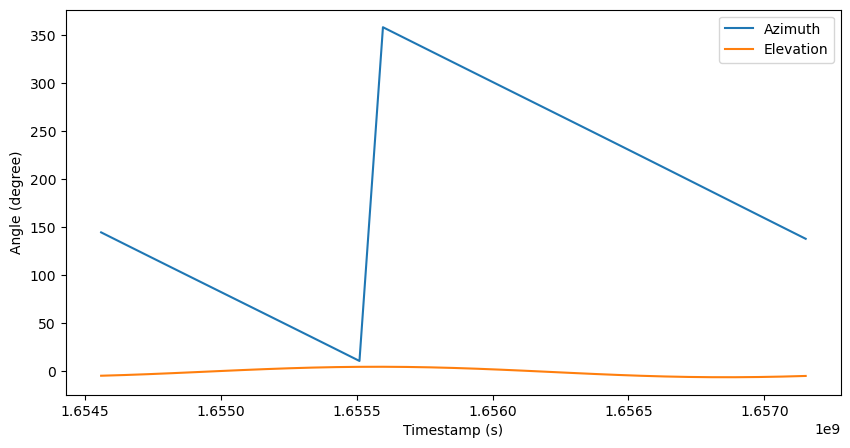

In [24]:
# Plot results

fig, axes = plt.subplots(1,1,figsize=(10,5), squeeze=False)

ax = axes[0,0]
ax.plot(ephe_df['unix_timestamp_s'], ephe_df['azimuth_deg'], label='Azimuth')
ax.plot(ephe_df['unix_timestamp_s'], ephe_df['elevation_deg'], label='Elevation')
ax.set_ylabel("Angle (degree)")
ax.set_xlabel("Timestamp (s)")
ax.legend()